In [19]:
"""
RNN From Scratch Implementation
================================
A complete implementation of a Recurrent Neural Network with detailed
forward and backward passes, demonstrating sequential processing.
"""

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict

class RNNCell:
    """
    A single RNN cell implementing the basic recurrent computation:
    h_t = tanh(W_hh @ h_{t-1} + W_xh @ x_t + b_h)
    """
    
    def __init__(self, input_size: int, hidden_size: int, seed: int = 42):
        """
        Initialize RNN cell parameters.
        
        Args:
            input_size: Dimension of input features
            hidden_size: Dimension of hidden state
            seed: Random seed for reproducibility
        """
        np.random.seed(seed)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        # Xavier initialization for weights
        self.W_xh = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.W_hh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_h = np.zeros((hidden_size, 1))
        
        # Cache for backward pass
        self.cache = {}
    
    def forward(self, x: np.ndarray, h_prev: np.ndarray) -> np.ndarray:
        """
        Forward pass for a single time step.
        
        Args:
            x: Input at current time step, shape (input_size, 1)
            h_prev: Hidden state from previous time step, shape (hidden_size, 1)
        
        Returns:
            h_next: Hidden state at current time step, shape (hidden_size, 1)
        """
        # Linear transformation
        z = self.W_xh @ x + self.W_hh @ h_prev + self.b_h
        
        # Activation function (tanh)
        h_next = np.tanh(z)
        
        # Cache values for backward pass
        self.cache = {
            'x': x,
            'h_prev': h_prev,
            'h_next': h_next,
            'z': z
        }
        
        return h_next
    
    def backward(self, dh_next: np.ndarray) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """
        Backward pass for a single time step.
        
        Args:
            dh_next: Gradient of loss w.r.t. hidden state, shape (hidden_size, 1)
        
        Returns:
            dx: Gradient w.r.t. input
            dh_prev: Gradient w.r.t. previous hidden state
            grads: Dictionary of parameter gradients
        """
        x = self.cache['x']
        h_prev = self.cache['h_prev']
        z = self.cache['z']
        
        # Gradient through tanh activation
        dz = dh_next * (1 - np.tanh(z) ** 2)
        
        # Parameter gradients
        dW_xh = dz @ x.T
        dW_hh = dz @ h_prev.T
        db_h = dz
        
        # Gradient w.r.t. inputs
        dx = self.W_xh.T @ dz
        dh_prev = self.W_hh.T @ dz
        
        grads = {
            'dW_xh': dW_xh,
            'dW_hh': dW_hh,
            'db_h': db_h
        }
        
        return dx, dh_prev, grads


In [20]:
class RNN:
    """
    Complete RNN model with multiple layers and time steps.
    """
    
    def __init__(self, input_size: int, hidden_size: int, output_size: int, 
                 learning_rate: float = 0.01, seed: int = 42):
        """
        Initialize RNN model.
        
        Args:
            input_size: Dimension of input features
            hidden_size: Dimension of hidden state
            output_size: Dimension of output
            learning_rate: Learning rate for optimization
            seed: Random seed
        """
        np.random.seed(seed)
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        
        # RNN cell
        self.cell = RNNCell(input_size, hidden_size, seed)
        
        # Output layer weights
        self.W_hy = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b_y = np.zeros((output_size, 1))
        
        # Training history
        self.loss_history = []
    
    def forward(self, X: np.ndarray, h0: np.ndarray = None) -> Tuple[np.ndarray, List[np.ndarray]]:
        """
        Forward pass through entire sequence.
        
        Args:
            X: Input sequence, shape (seq_length, input_size, batch_size)
            h0: Initial hidden state, shape (hidden_size, batch_size)
        
        Returns:
            outputs: Output predictions for each time step
            hidden_states: Hidden states for each time step
        """
        seq_length = X.shape[0]
        batch_size = X.shape[2] if len(X.shape) > 2 else 1
        
        # Initialize hidden state
        if h0 is None:
            h = np.zeros((self.hidden_size, batch_size))
        else:
            h = h0
        
        hidden_states = [h]
        outputs = []
        
        # Process each time step
        for t in range(seq_length):
            x_t = X[t].reshape(self.input_size, -1)
            h = self.cell.forward(x_t, h)
            hidden_states.append(h)
            
            # Compute output
            y_t = self.W_hy @ h + self.b_y
            outputs.append(y_t)
        
        return np.array(outputs), hidden_states
    
    def backward(self, X: np.ndarray, Y: np.ndarray, outputs: np.ndarray, 
                 hidden_states: List[np.ndarray]) -> float:
        """
        Backward pass through time (BPTT).
        
        Args:
            X: Input sequence
            Y: Target sequence
            outputs: Predicted outputs
            hidden_states: Cached hidden states
        
        Returns:
            loss: Mean squared error loss
        """
        seq_length = X.shape[0]
        
        # Initialize gradient accumulators
        dW_xh = np.zeros_like(self.cell.W_xh)
        dW_hh = np.zeros_like(self.cell.W_hh)
        db_h = np.zeros_like(self.cell.b_h)
        dW_hy = np.zeros_like(self.W_hy)
        db_y = np.zeros_like(self.b_y)
        
        # Initialize gradient flowing back
        dh_next = np.zeros_like(hidden_states[0])
        
        # Compute loss
        loss = 0
        
        # Backward pass through time
        for t in reversed(range(seq_length)):
            y_t = outputs[t]
            target_t = Y[t].reshape(self.output_size, -1)
            
            # Output layer gradient
            dy = y_t - target_t
            loss += np.sum(dy ** 2)
            
            dW_hy += dy @ hidden_states[t + 1].T
            db_y += np.sum(dy, axis=1, keepdims=True)
            
            # Gradient flowing into hidden state
            dh = self.W_hy.T @ dy + dh_next
            
            # Backward through RNN cell
            x_t = X[t].reshape(self.input_size, -1)
            self.cell.cache = {
                'x': x_t,
                'h_prev': hidden_states[t],
                'h_next': hidden_states[t + 1],
                'z': np.arctanh(hidden_states[t + 1])  # Approximate for demo
            }
            
            _, dh_next, grads = self.cell.backward(dh)
            
            # Accumulate gradients
            dW_xh += grads['dW_xh']
            dW_hh += grads['dW_hh']
            db_h += np.sum(grads['db_h'], axis=1, keepdims=True)
        
        # Gradient clipping to prevent exploding gradients
        for grad in [dW_xh, dW_hh, db_h, dW_hy, db_y]:
            np.clip(grad, -5, 5, out=grad)
        
        # Update parameters
        self.cell.W_xh -= self.learning_rate * dW_xh
        self.cell.W_hh -= self.learning_rate * dW_hh
        self.cell.b_h -= self.learning_rate * db_h
        self.W_hy -= self.learning_rate * dW_hy
        self.b_y -= self.learning_rate * db_y
        
        return loss / seq_length
    
    def train_step(self, X: np.ndarray, Y: np.ndarray) -> float:
        """
        Single training step: forward + backward + update.
        
        Args:
            X: Input sequence
            Y: Target sequence
        
        Returns:
            loss: Training loss
        """
        # Forward pass
        outputs, hidden_states = self.forward(X)
        
        # Backward pass
        loss = self.backward(X, Y, outputs, hidden_states)
        
        self.loss_history.append(loss)
        return loss
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions on input sequence."""
        outputs, _ = self.forward(X)
        return outputs

In [21]:
# ===== DEMONSTRATION =====

def generate_sine_data(seq_length: int = 50, num_sequences: int = 100) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate synthetic sine wave data for sequence prediction.
    Task: Predict next value in sine wave sequence.
    """
    X_data = []
    Y_data = []
    
    for _ in range(num_sequences):
        # Random phase and frequency
        phase = np.random.uniform(0, 2 * np.pi)
        freq = np.random.uniform(0.5, 2.0)
        
        # Generate sine wave
        t = np.linspace(0, 4 * np.pi, seq_length + 1)
        sine_wave = np.sin(freq * t + phase)
        
        # Input: first seq_length points
        # Target: shifted by one (next value prediction)
        X_data.append(sine_wave[:-1])
        Y_data.append(sine_wave[1:])
    
    X = np.array(X_data).reshape(num_sequences, seq_length, 1)
    Y = np.array(Y_data).reshape(num_sequences, seq_length, 1)
    
    # Reshape to (seq_length, input_size, num_sequences)
    X = np.transpose(X, (1, 2, 0))
    Y = np.transpose(Y, (1, 2, 0))
    
    return X, Y


def visualize_results(rnn: RNN, X_test: np.ndarray, Y_test: np.ndarray):
    """Visualize training progress and predictions."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Loss curve
    axes[0, 0].plot(rnn.loss_history, linewidth=2, color='#6366f1')
    axes[0, 0].set_xlabel('Training Step', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Sample predictions
    predictions = rnn.predict(X_test)
    
    sample_idx = 0
    axes[0, 1].plot(Y_test[:, 0, sample_idx], label='Ground Truth', 
                    linewidth=2, color='#10b981', linestyle='--')
    axes[0, 1].plot(predictions[:, 0, sample_idx], label='Prediction', 
                    linewidth=2, color='#6366f1')
    axes[0, 1].set_xlabel('Time Step', fontsize=12)
    axes[0, 1].set_ylabel('Value', fontsize=12)
    axes[0, 1].set_title('Sample Prediction', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Multiple sequence predictions
    for i in range(min(5, X_test.shape[2])):
        axes[1, 0].plot(predictions[:, 0, i], alpha=0.6, linewidth=1.5)
    axes[1, 0].set_xlabel('Time Step', fontsize=12)
    axes[1, 0].set_ylabel('Value', fontsize=12)
    axes[1, 0].set_title('Multiple Sequence Predictions', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Error distribution
    errors = np.abs(predictions - Y_test)
    axes[1, 1].hist(errors.flatten(), bins=50, color='#8b5cf6', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('Absolute Error', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('rnn_results.png', dpi=300, bbox_inches='tight')
    print("✓ Visualization saved as 'rnn_results.png'")
    plt.show()


def main():
    """Main demonstration of RNN from scratch."""
    
    print("=" * 60)
    print("RNN FROM SCRATCH - COMPLETE IMPLEMENTATION")
    print("=" * 60)
    
    # Hyperparameters
    input_size = 1
    hidden_size = 32
    output_size = 1
    seq_length = 50
    num_sequences = 100
    epochs = 100
    learning_rate = 0.001
    
    print("\n📋 Configuration:")
    print(f"   Input Size: {input_size}")
    print(f"   Hidden Size: {hidden_size}")
    print(f"   Output Size: {output_size}")
    print(f"   Sequence Length: {seq_length}")
    print(f"   Training Sequences: {num_sequences}")
    print(f"   Epochs: {epochs}")
    print(f"   Learning Rate: {learning_rate}")
    
    # Generate data
    print("\n📊 Generating sine wave data...")
    X_train, Y_train = generate_sine_data(seq_length, num_sequences)
    X_test, Y_test = generate_sine_data(seq_length, 20)
    print(f"   Training data shape: {X_train.shape}")
    print(f"   Test data shape: {X_test.shape}")
    
    # Initialize RNN
    print("\n🧠 Initializing RNN...")
    rnn = RNN(input_size, hidden_size, output_size, learning_rate)
    
    # Count parameters
    total_params = (rnn.cell.W_xh.size + rnn.cell.W_hh.size + rnn.cell.b_h.size + 
                   rnn.W_hy.size + rnn.b_y.size)
    print(f"   Total parameters: {total_params:,}")
    
    # Training loop
    print("\n🚀 Training RNN...")
    print("-" * 60)
    
    for epoch in range(epochs):
        loss = rnn.train_step(X_train, Y_train)
        
        if (epoch + 1) % 10 == 0:
            # Test evaluation
            test_outputs, _ = rnn.forward(X_test)
            test_loss = np.mean((test_outputs - Y_test) ** 2)
            print(f"Epoch {epoch + 1:3d}/{epochs} | "
                  f"Train Loss: {loss:.6f} | Test Loss: {test_loss:.6f}")
    
    print("-" * 60)
    print("✓ Training complete!")
    
    # Final evaluation
    print("\n📈 Final Evaluation:")
    predictions = rnn.predict(X_test)
    mse = np.mean((predictions - Y_test) ** 2)
    mae = np.mean(np.abs(predictions - Y_test))
    print(f"   Test MSE: {mse:.6f}")
    print(f"   Test MAE: {mae:.6f}")
    
    # Visualize
    print("\n📊 Generating visualizations...")
    visualize_results(rnn, X_test, Y_test)
    
    print("\n" + "=" * 60)
    print("DEMONSTRATION COMPLETE!")
    print("=" * 60)



RNN FROM SCRATCH - COMPLETE IMPLEMENTATION

📋 Configuration:
   Input Size: 1
   Hidden Size: 32
   Output Size: 1
   Sequence Length: 50
   Training Sequences: 100
   Epochs: 100
   Learning Rate: 0.001

📊 Generating sine wave data...
   Training data shape: (50, 1, 100)
   Test data shape: (50, 1, 20)

🧠 Initializing RNN...
   Total parameters: 1,121

🚀 Training RNN...
------------------------------------------------------------
Epoch  10/100 | Train Loss: 15.992036 | Test Loss: 0.088426
Epoch  20/100 | Train Loss: 12.113086 | Test Loss: 0.069676
Epoch  30/100 | Train Loss: 10.564460 | Test Loss: 0.061081
Epoch  40/100 | Train Loss: 9.481901 | Test Loss: 0.056310
Epoch  50/100 | Train Loss: 8.821008 | Test Loss: 0.053038
Epoch  60/100 | Train Loss: 8.299996 | Test Loss: 0.051324
Epoch  70/100 | Train Loss: 7.777743 | Test Loss: 0.048230
Epoch  80/100 | Train Loss: 7.385543 | Test Loss: 0.046113
Epoch  90/100 | Train Loss: 6.907649 | Test Loss: 0.044447
Epoch 100/100 | Train Loss: 6.5

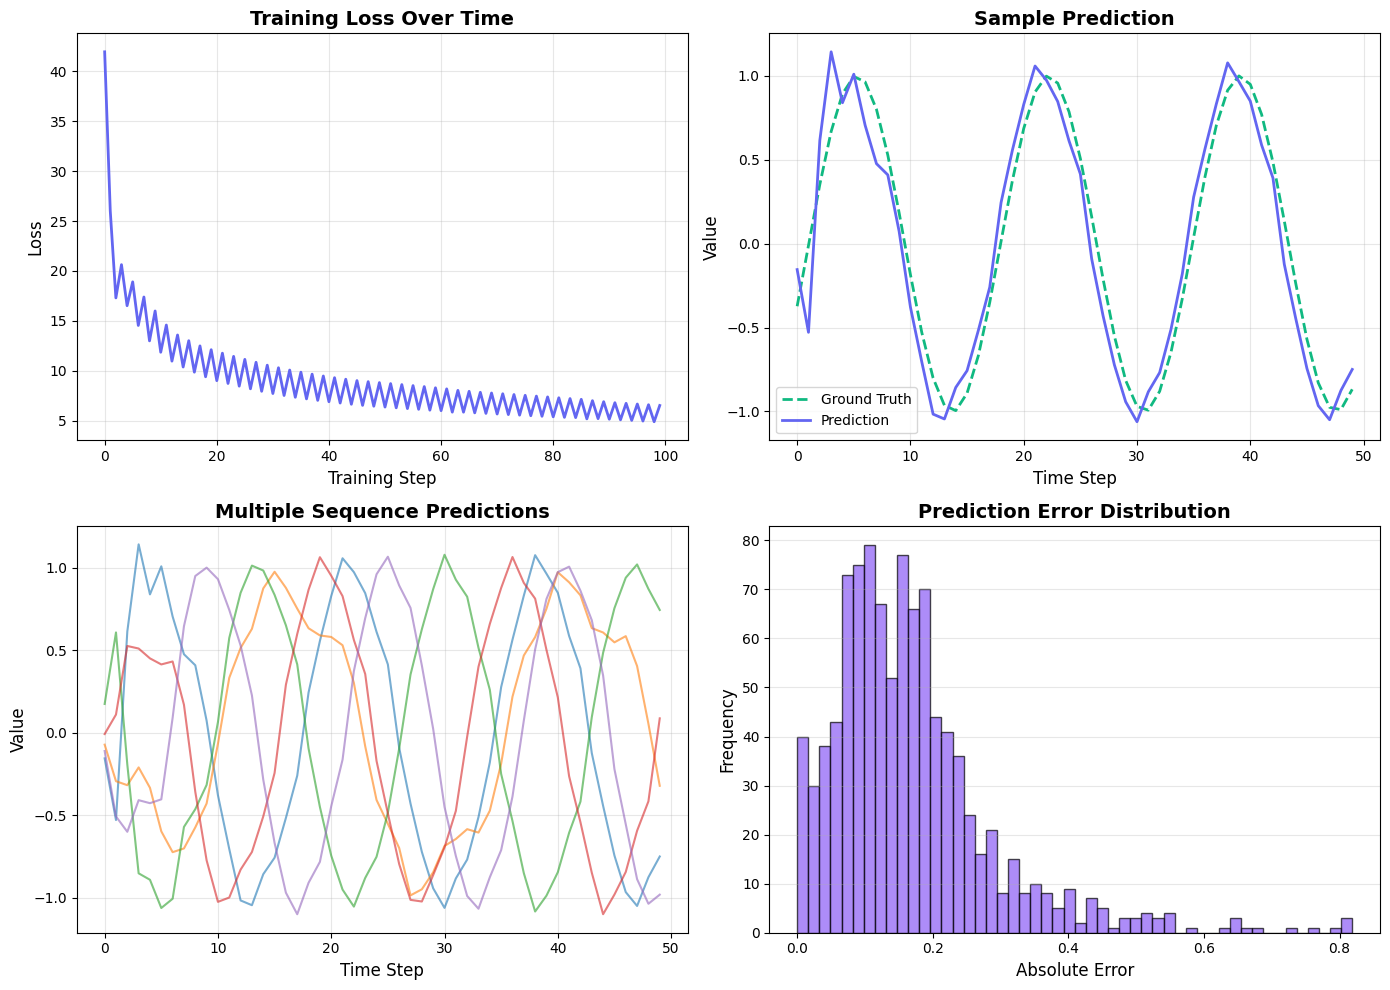


DEMONSTRATION COMPLETE!


In [22]:
if __name__ == "__main__":
    main()